In [24]:
import pandas as pd
import numpy as np
import pyodbc  
from datetime import datetime 
import matplotlib.pylab as plt
from sklearn.cluster import KMeans

In [25]:
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=htian;PWD=HeLeNtIAn52!")
cursor = conn.cursor()

In [105]:
df = pd.read_sql("SELECT C.CustomerID, C.SalesOffice, C.Address1, C.City, C.State, S.Unit_Price, S.Order_Qty, S.Net_Value_item_level, S.Line_Req_Deliv_Date, P.ProductCategory, P.MasterSKU, P.ISCORE FROM [EDW].[sap_zva05_fct] S inner JOIN [EDW].[CUSTOMER_DIM] C ON C.CustomerID = S.Sold_To_Party inner join [EDW].[PRODUCT_DIM] P ON P.ProductIDOLD = S.Material WHERE (C.SalesOffice='STD' or C.SalesOffice='HYB') and (S.SL_Status = 'active sl') and (S.Reason_for_Rejection is null) and (S.Order_type != 'ZARF' and S.Order_type != 'ZARM' and S.Order_type != 'ZEG2' and S.Order_type != 'ZERF' and S.Order_type != 'ZERM' and S.Order_type != 'ZRE') and (C.customerID!='91860' and C.customerid!='0000107894' and C.customerid !='0000114883') ", conn)


In [106]:
df.head()

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
0,0000101263,STD,585 Freshfields Dr,Johns Island,SC,181.99,2.0,363.98,2017-02-22,Soft Cooler,Flip 12,TRUE
1,0000103158,STD,8008 E Sligh Ave,Tampa,FL,259.99,2.0,519.98,2017-03-06,Hard Cooler,Tundra 65,TRUE
2,0000113638,STD,3505 Buck Owens Blvd,Bakersfield,CA,93.82,2.0,187.63,2017-05-22,Drinkware,R1G Jug,TRUE
3,0000100507,STD,1505 Hurst Creek Rd,Austin,TX,13.02,3.0,39.06,2017-04-14,Gear & Apparel,Shirts,FALSE
4,0000103664,STD,4600 2nd Ave,Kearney,NE,162.49,1.0,162.49,2017-04-20,Hard Cooler,Roadie 20,TRUE


In [107]:
# missing values check
df.isnull().sum()

CustomerID                0
SalesOffice               0
Address1                193
City                      0
State                   291
Unit_Price                0
Order_Qty                 0
Net_Value_item_level      0
Line_Req_Deliv_Date       0
ProductCategory           0
MasterSKU                 0
ISCORE                    0
dtype: int64

In [108]:
#Show rows which address is null
df[pd.isnull(df.Address1)]

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
923,0000100273,STD,None,Many,LA,194.99,6.0,1169.94,2017-09-07,Soft Cooler,Hopper2.0 20,TRUE
6095,0000100273,STD,None,Many,LA,259.99,4.0,1039.96,2017-10-12,Soft Cooler,Hopper2.0 40,TRUE
6350,0000100273,STD,None,Many,LA,357.49,1.0,357.49,2017-07-11,Hard Cooler,Tundra 125,TRUE
7296,0000100273,STD,None,Many,LA,20.99,48.0,1007.52,2017-09-07,Drinkware,R30 Tumbler,TRUE
8961,0000100273,STD,None,Many,LA,292.49,4.0,1169.96,2018-01-18,Hard Cooler,Tundra 75,TRUE
10315,0000100273,STD,None,Many,LA,14.99,48.0,719.52,2017-06-08,Drinkware,R20 Tumbler,TRUE
10944,0000100273,STD,None,Many,LA,259.99,1.0,259.99,2017-06-08,Hard Cooler,Tundra 65,TRUE
13720,0000100273,STD,None,Many,LA,17.99,48.0,863.52,2017-06-08,Drinkware,R30 Tumbler,TRUE
14362,0000100273,STD,None,Many,LA,41.99,16.0,671.84,2017-05-02,Drinkware,R64 Bottle,TRUE
19547,0000100273,STD,None,Many,LA,20.99,30.0,629.70,2017-05-02,Hard Cooler,Cable Locks,FALSE


In [109]:
# Fill the address from table [EDW].[SHIPTO_DIM]: CustomerID = '0000100273'
df['Address1'].fillna("895 SABINE ST", inplace = True)

In [110]:
# Find customerID 
list(set(df.CustomerID[pd.isnull(df.State)]))
df[pd.isnull(df.State)].head()

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
212,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,2.74,6.0,16.44,2017-11-30,Gear & Apparel,Sticker,FALSE
2103,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,29.99,8.0,239.92,2018-05-22,Soft Cooler,SideKick,FALSE
2496,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,11.99,6.0,71.94,2017-11-30,Drinkware,R10 Lowball,TRUE
2556,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,11.99,6.0,71.94,2018-02-21,Drinkware,R10 Lowball,TRUE
5906,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,17.99,6.0,107.94,2017-11-30,Drinkware,R20 Tumbler,TRUE


In [112]:
# Find State according to Address1 and City and fill in 
df['State'][df.CustomerID=='0000114883']='MA'

C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [113]:
# Location outside US, ignore
list(set(df['City'][df.CustomerID=='0000119007']))   

['Puntarenas']

In [114]:
# Location outside US, ignore
list(set(df['City'][df.CustomerID=='0000118196']))   

['Ornjestad']

In [115]:
# Check null value exists or not
df.isnull().sum()

CustomerID                0
SalesOffice               0
Address1                  0
City                      0
State                   291
Unit_Price                0
Order_Qty                 0
Net_Value_item_level      0
Line_Req_Deliv_Date       0
ProductCategory           0
MasterSKU                 0
ISCORE                    0
dtype: int64

In [116]:
df[(df['Net_Value_item_level']<=0) | (df['Unit_Price']<=0)].head()

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
273,0000104440,STD,19405 Bandera Rd,Helotes,TX,0.0,24.0,0.0,2017-06-15,Drinkware,Slider Lid R30,FALSE
333,0000106469,STD,3507 E Racine St,Janesville,WI,0.0,5.0,0.0,2018-01-10,Drinkware,Slider Lid R30,FALSE
372,0000101711,STD,420 Azalea Square Blvd,Summerville,SC,0.0,6.0,0.0,2017-06-05,Hard Cooler,Roadie 20,TRUE
388,0000101090,STD,734 West Front St,Traverse City,MI,0.0,1.0,0.0,2017-05-04,Drinkware,R10/20 Lid,FALSE
432,0000100358,STD,409 Roland Ave,Holly Ridge,NC,0.0,1.0,0.0,2017-06-11,Hard Cooler,Roadie 20,TRUE


In [118]:
df['Line_Req_Deliv_Date'] = pd.to_datetime(df['Line_Req_Deliv_Date'])  

In [119]:
df = df[(df.Line_Req_Deliv_Date<'2018-1-01') & (df.Line_Req_Deliv_Date>='2017-1-01')]

In [120]:
################################################################# group order quantity by STD

In [121]:
df

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
0,0000101263,STD,585 Freshfields Dr,Johns Island,SC,181.99,2.0,363.98,2017-02-22,Soft Cooler,Flip 12,TRUE
1,0000103158,STD,8008 E Sligh Ave,Tampa,FL,259.99,2.0,519.98,2017-03-06,Hard Cooler,Tundra 65,TRUE
2,0000113638,STD,3505 Buck Owens Blvd,Bakersfield,CA,93.82,2.0,187.63,2017-05-22,Drinkware,R1G Jug,TRUE
3,0000100507,STD,1505 Hurst Creek Rd,Austin,TX,13.02,3.0,39.06,2017-04-14,Gear & Apparel,Shirts,FALSE
4,0000103664,STD,4600 2nd Ave,Kearney,NE,162.49,1.0,162.49,2017-04-20,Hard Cooler,Roadie 20,TRUE
5,0000103395,STD,825 Bay St,Beaufort,SC,11.99,12.0,143.88,2017-10-25,Drinkware,R10 Lowball,TRUE
6,0000103300,STD,12749 Louisiana 28 E,Pineville,LA,9.99,12.0,119.88,2017-02-23,Gear & Apparel,Headgear,FALSE
8,0000101539,STD,7820 S Broadway Ave,Tyler,TX,18.75,12.0,225.05,2017-11-01,Drinkware,R20 Tumbler,TRUE
10,0000100444,STD,6408 Crescent Loop 1,Laredo,TX,14.99,42.0,629.58,2017-10-13,Drinkware,R Colsters,TRUE
11,0000104246,STD,114 Mines Rd,Blue Hill,ME,59.99,2.0,119.98,2017-08-07,Drinkware,R1/2G Jug,TRUE


In [122]:
df1 = df['Order_Qty'].groupby(df['CustomerID']).sum()

In [123]:
df1 = df1.to_frame()

In [124]:
df1 = df1.reset_index()

In [125]:
df1=df1.sort_values(by=["Order_Qty"],ascending=[False])

In [126]:
df1.head()

,CustomerID,Order_Qty
1323,0000101813,1282252.0
529,0000100710,332234.0
1963,0000102853,331335.0
1347,0000101886,291771.0
643,0000100873,226194.0


In [127]:

#plt.scatter(range(len(df1)), df1.Order_Qty)

In [128]:
df1.describe()

,Order_Qty
count,5.360000e+03
mean,1.888966e+03
std,2.025496e+04
min,1.000000e+00
25%,1.260000e+02
50%,4.200000e+02
75%,1.011000e+03
max,1.282252e+06


In [129]:
from sklearn.cluster import KMeans
X = np.array(df1.Order_Qty.iloc[1:].reshape(-1,1))
kmeans = KMeans(n_clusters = 4, random_state=0).fit(X)
kmeans.labels_

C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


array([2, 2, 2, ..., 0, 0, 0])

In [130]:
Class=[]
Class.append(kmeans.labels_[0])
Class+=list(kmeans.labels_)

In [131]:
Class

[2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [132]:
df6=df1.copy()

In [133]:
df6["Class"] = Class

Text(0.5,1,'Logarithmic Overall Order-Qty')

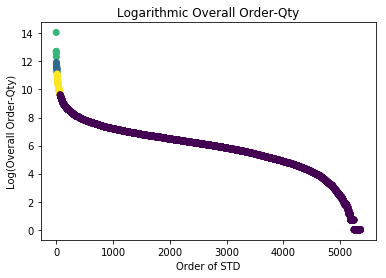

In [134]:
plt.scatter(range(len(df6)), np.log(df6.Order_Qty), c=df6.Class)
plt.xlabel('Order of STD')
plt.ylabel('Log(Overall Order-Qty)')
plt.title('Logarithmic Overall Order-Qty')

In [135]:
len(df6[df6.Class==3])

54

In [136]:
len(df6[df6.Class==2])

5

In [137]:
len(df6[df6.Class==1])

12

In [138]:
len(df6[df6.Class==0])

5289

In [139]:
df6.iloc[:75]

,CustomerID,Order_Qty,Class
1323,0000101813,1282252.0,2
529,0000100710,332234.0,2
1963,0000102853,331335.0,2
1347,0000101886,291771.0,2
643,0000100873,226194.0,2
297,0000100395,152031.0,1
4139,0000106469,132909.0,1
1255,0000101711,126822.0,1
1662,0000102433,115904.0,1
754,0000101026,115840.0,1


In [141]:
################################################################## group Net_Value_item_level(Overall Value) by STD

In [142]:
df3 = df['Net_Value_item_level'].groupby(df['CustomerID']).sum()

In [143]:
df3 = df3.to_frame()

In [144]:
df3 = df3.reset_index()

In [145]:
df3.head()

,CustomerID,Net_Value_item_level
0,0000100002,9765.53
1,0000100004,48293.68
2,0000100005,18855.69
3,0000100006,160408.82
4,0000100007,55401.02


In [146]:
df3.describe()

,Net_Value_item_level
count,5.360000e+03
mean,4.929177e+04
std,4.868084e+05
min,0.000000e+00
25%,4.533235e+03
50%,1.233263e+04
75%,3.015384e+04
max,3.143766e+07


In [147]:
# exist Net_Value_item_level = 0, delete them
df3=df3.sort_values(by=["Net_Value_item_level"],ascending=[False])
len(df3[df3.Net_Value_item_level==0])

84

In [148]:
df3=df3[:-84]

In [149]:
# because the maximum value is much larger than the secondard largest value. To reduce the influence, I remove the largest value

In [150]:
X = np.array(df3.Net_Value_item_level.iloc[1:].reshape(-1,1))

C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [151]:
kmeans = KMeans(n_clusters = 3, random_state=0).fit(X)

In [152]:
Class=[]
Class.append(kmeans.labels_[0])
Class+=list(kmeans.labels_)

In [153]:
df4=df3.copy()

In [154]:
df4["Class"] = Class

Text(0.5,1,'Logarithmic Overall_Value')

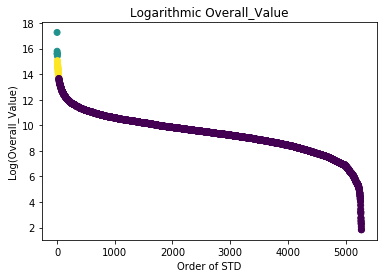

In [155]:
plt.scatter(range(len(df4)), np.log(df4.Net_Value_item_level), c=df4.Class)
plt.xlabel('Order of STD')
plt.ylabel('Log(Overall_Value)')
plt.title('Logarithmic Overall_Value')

In [180]:
len(df4[df4.Class==1])

6

In [181]:
len(df4[df4.Class==2])

25

In [157]:
df4.iloc[:35]

,CustomerID,Net_Value_item_level,Class
1323,0000101813,31437662.77,1
529,0000100710,7197653.94,1
1963,0000102853,5968593.69,1
643,0000100873,5968436.77,1
1347,0000101886,5848902.11,1
297,0000100395,5013714.94,1
4205,0000106843,3453501.11,2
1255,0000101711,2916348.47,2
234,0000100315,2814160.46,2
1662,0000102433,2526935.53,2


In [158]:
len(df4[df4.Class==1])

6

In [159]:
len(df4[df4.Class==2])

25

In [160]:
################################################# Analysing diff percentage of product category in different Order_Qty STD

In [161]:
# Drinkware
dfD = df[df.ProductCategory=='Drinkware']

dfd = dfD['Order_Qty'].groupby(df['CustomerID']).sum()

dfd = dfd.to_frame()

dfd = dfd.reset_index()

In [162]:
# Soft Cooler
dfS = df[df.ProductCategory=='Soft Cooler']

dfs = dfS['Order_Qty'].groupby(df['CustomerID']).sum()

dfs = dfs.to_frame()

dfs = dfs.reset_index()

In [163]:
# Hard Cooler
dfH = df[df.ProductCategory=='Hard Cooler']

dfh = dfH['Order_Qty'].groupby(df['CustomerID']).sum()

dfh = dfh.to_frame()

dfh = dfh.reset_index()

In [164]:
# merge above dataframe together

DF=pd.merge(dfd, dfs,  on='CustomerID', how='outer')

DF=pd.merge(DF, dfh,  on='CustomerID', how='outer')

DF=DF.rename(index=str, columns={"CustomerID": "CustomerID", "Order_Qty_x": "DW_Qty","Order_Qty_y": "SK_Qty", "Order_Qty": "HK_Qty"})

DF=pd.merge(DF, df6,  on='CustomerID', how='outer')

DF=DF.fillna(0)


In [165]:
DF.head()

,CustomerID,DW_Qty,SK_Qty,HK_Qty,Order_Qty,Class
0,0000100002,84.0,2.0,44.0,130.0,0
1,0000100004,1622.0,97.0,98.0,1889.0,0
2,0000100005,240.0,10.0,75.0,484.0,0
3,0000100006,4712.0,124.0,303.0,5708.0,0
4,0000100007,822.0,189.0,54.0,1092.0,0


In [166]:
DF1 = DF.copy()
DF1['DW_Qty'] = DF.DW_Qty/DF.Order_Qty
DF1['SK_Qty'] = DF.SK_Qty/DF.Order_Qty
DF1['HK_Qty'] = DF.HK_Qty/DF.Order_Qty

In [167]:
DF1.head()

,CustomerID,DW_Qty,SK_Qty,HK_Qty,Order_Qty,Class
0,0000100002,0.646154,0.015385,0.338462,130.0,0
1,0000100004,0.858655,0.051350,0.051879,1889.0,0
2,0000100005,0.495868,0.020661,0.154959,484.0,0
3,0000100006,0.825508,0.021724,0.053083,5708.0,0
4,0000100007,0.752747,0.173077,0.049451,1092.0,0


In [176]:
qq=DF1.groupby('Class', as_index=False)['DW_Qty', 'SK_Qty', 'HK_Qty'].mean()
qq=qq.rename(index=str, columns={'DW_Qty':'Drinkware', 'SK_Qty': 'Soft Cooler', 'HK_Qty':'Hard Cooler'})
qq.Class = ['Small', 'Large', 'Medium','Extreme Large']
qq=qq.reindex(['0', '3', '1','2'])

In [177]:
qq

,Class,Drinkware,Soft Cooler,Hard Cooler
0,Small,0.729003,0.057316,0.136597
3,Extreme Large,0.886128,0.024192,0.029393
1,Large,0.903032,0.019534,0.032102
2,Medium,0.882652,0.024441,0.029995


C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0.5,1,'Average % of Order Quantity in different Class')

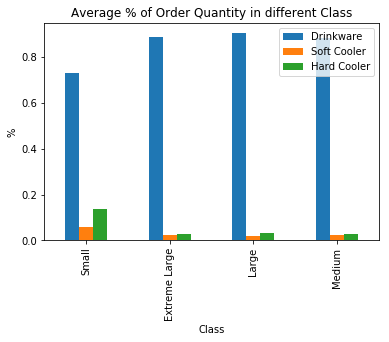

In [178]:
qq.plot(x='Class', y=['Drinkware', 'Soft Cooler', 'Hard Cooler'], kind="bar")
plt.ylabel('%')
plt.title('Average % of Order Quantity in different Class')

In [179]:
DF[(DF['Class']==3) | (DF['Class']==1)]

,CustomerID,DW_Qty,SK_Qty,HK_Qty,Order_Qty,Class
123,0000100169,17152.0,846.0,430.0,20147.0,3
133,0000100189,16378.0,523.0,123.0,17024.0,3
198,0000100283,22730.0,556.0,1152.0,32948.0,3
218,0000100315,91225.0,2287.0,5161.0,100365.0,1
243,0000100349,22844.0,2576.0,3156.0,29057.0,3
259,0000100371,89993.0,346.0,1069.0,91590.0,1
272,0000100395,126831.0,4355.0,12599.0,152031.0,1
417,0000100635,87808.0,1058.0,1712.0,95743.0,1
529,0000100812,25776.0,2219.0,2523.0,33440.0,3
612,0000100926,26048.0,441.0,471.0,28098.0,3


In [172]:
test=DF1[(DF1['Class']==3) | (DF1['Class']==1)]

In [173]:
test

,CustomerID,DW_Qty,SK_Qty,HK_Qty,Order_Qty,Class
123,0000100169,0.851343,0.041991,0.021343,20147.0,3
133,0000100189,0.962054,0.030721,0.007225,17024.0,3
198,0000100283,0.689875,0.016875,0.034964,32948.0,3
218,0000100315,0.908932,0.022787,0.051422,100365.0,1
243,0000100349,0.786179,0.088653,0.108614,29057.0,3
259,0000100371,0.982564,0.003778,0.011672,91590.0,1
272,0000100395,0.834244,0.028645,0.082871,152031.0,1
417,0000100635,0.917122,0.011050,0.017881,95743.0,1
529,0000100812,0.770813,0.066358,0.075449,33440.0,3
612,0000100926,0.927041,0.015695,0.016763,28098.0,3


Text(0.5,1,'Logarithmic Overall_Value')

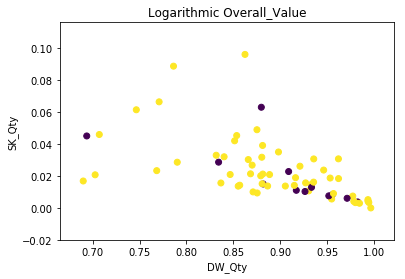

In [174]:
plt.scatter(x=tt.DW_Qty, y= tt.SK_Qty, c=tt.Class)
plt.xlabel('DW_Qty')
plt.ylabel('SK_Qty')
plt.title('Logarithmic Overall_Value')